In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

# Đọc dữ liệu
df = pd.read_csv('/content/Microsoft_Stock.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Chọn cột giá
price_col = 'Close' if 'Close' in df.columns else df.columns[-1]
data = df[price_col].values

In [16]:
def kalman_filter(zs):
    n = len(zs)
    x = np.zeros(n)
    P = np.zeros(n)

    A = 1
    H = 1
    Q = 1e-5
    R = 0.1**2
    x_est = zs[0]
    p_est = 1.0

    for t in range(n):
        x_pred = A * x_est
        p_pred = A * p_est * A + Q

        K = p_pred * H / (H * p_pred * H + R)
        x_est = x_pred + K * (zs[t] - H * x_pred)
        p_est = (1 - K * H) * p_pred

        x[t] = x_est
        P[t] = p_est

    return x

kalman_preds = kalman_filter(data)

In [17]:
def particle_filter(zs, N=500):
    particles = np.random.normal(zs[0], 1, size=N)
    weights = np.ones(N) / N
    estimates = []

    for z in zs:
        particles += np.random.normal(0, 1, N)
        weights *= np.exp(-0.5 * (z - particles)**2)
        weights += 1.e-300
        weights /= np.sum(weights)

        estimate = np.average(particles, weights=weights)
        estimates.append(estimate)

        cumulative_sum = np.cumsum(weights)
        cumulative_sum[-1] = 1.
        indexes = np.searchsorted(cumulative_sum, np.random.rand(N))

        particles = particles[indexes]
        weights.fill(1.0 / N)

    return estimates

particle_preds = particle_filter(data)

In [18]:
def viterbi_gaussian(obs, n_states=3, n_iter=10):
    np.random.seed(42)
    n = len(obs)
    means = np.random.choice(obs, n_states)
    vars_ = np.full(n_states, np.var(obs))
    trans = np.full((n_states, n_states), 1.0 / n_states)
    pi = np.full(n_states, 1.0 / n_states)

    for _ in range(n_iter):
        log_probs = np.zeros((n, n_states))
        backptr = np.zeros((n, n_states), dtype=int)

        for s in range(n_states):
            log_probs[0, s] = np.log(pi[s]) - 0.5 * ((obs[0] - means[s]) ** 2) / vars_[s] - 0.5 * np.log(2 * np.pi * vars_[s])

        for t in range(1, n):
            for s in range(n_states):
                trans_probs = log_probs[t - 1] + np.log(trans[:, s])
                best_prev = np.argmax(trans_probs)
                backptr[t, s] = best_prev
                log_emission = -0.5 * ((obs[t] - means[s]) ** 2) / vars_[s] - 0.5 * np.log(2 * np.pi * vars_[s])
                log_probs[t, s] = trans_probs[best_prev] + log_emission

        states = np.zeros(n, dtype=int)
        states[-1] = np.argmax(log_probs[-1])
        for t in range(n - 2, -1, -1):
            states[t] = backptr[t + 1, states[t + 1]]

        for s in range(n_states):
            assigned = obs[states == s]
            if len(assigned) > 0:
                means[s] = np.mean(assigned)
                vars_[s] = np.var(assigned) + 1e-3

    preds = means[states]
    return preds

viterbi_preds = viterbi_gaussian(data)

,RMSE,MAE
Kalman,12.508538,10.349638
Particle,3.159927,1.913978
Viterbi,22.875427,18.908522


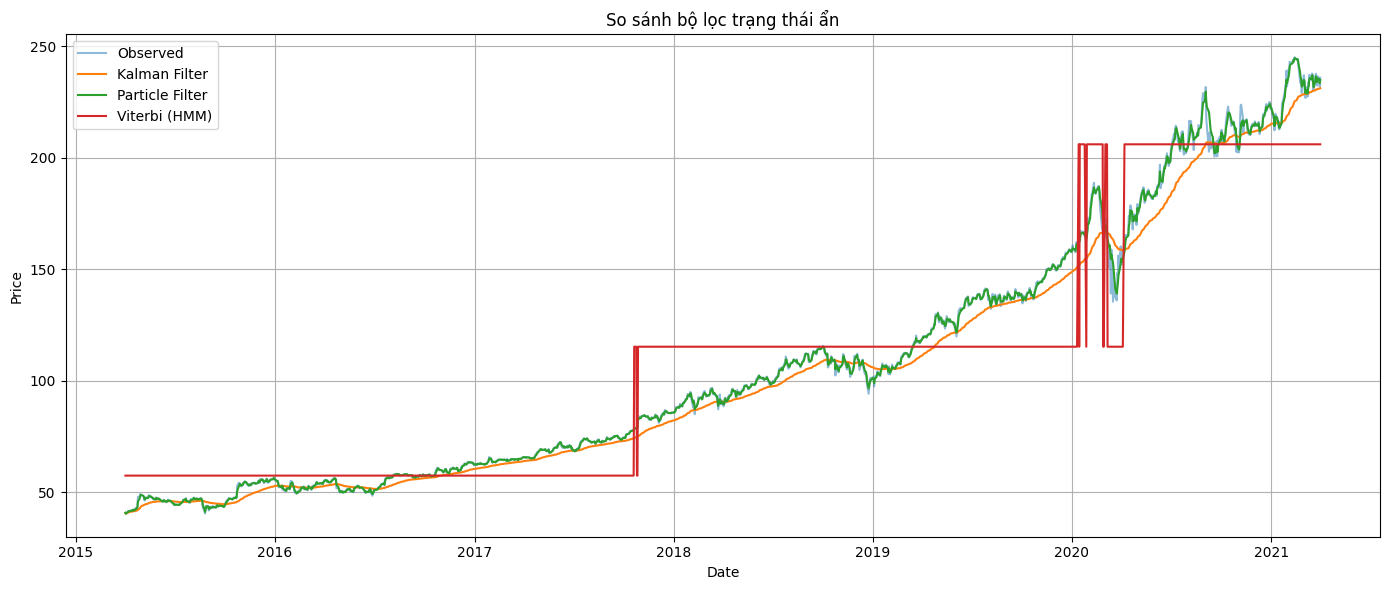

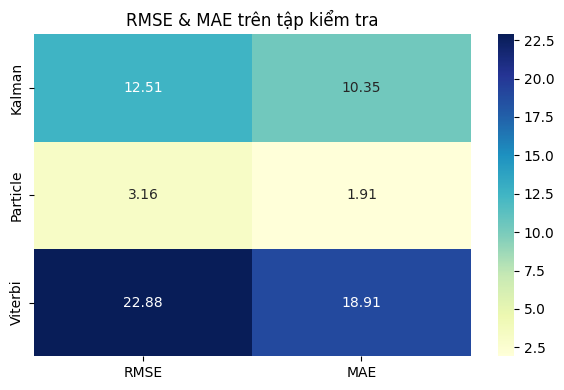

In [19]:
def compute_metrics(true, pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAE': mean_absolute_error(true, pred)
    }

metrics = pd.DataFrame({
    'Kalman': compute_metrics(data[train_size:], kalman_preds[train_size:]),
    'Particle': compute_metrics(data[train_size:], particle_preds[train_size:]),
    'Viterbi': compute_metrics(data[train_size:], viterbi_preds[train_size:])
}).T

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], data, label='Observed', alpha=0.5)
plt.plot(df['Date'], kalman_preds, label='Kalman Filter')
plt.plot(df['Date'], particle_preds, label='Particle Filter')
plt.plot(df['Date'], viterbi_preds, label='Viterbi (HMM)')
plt.title('So sánh bộ lọc trạng thái ẩn')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(6, 4))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("RMSE & MAE trên tập kiểm tra")
plt.tight_layout()

metrics